In [43]:
#/* *************************************************************************** */
#/*                                                                             */
#/*   XXXVIII PhD Course on Big Data & AI @ Mercatorum University               */
#/*                                                                             */
#/*   By: vstile <vittoriostile@gmail.com>                                      */
#/*   Link-in-bio page: https://linktr.ee/vstile                                */
#/*                                                                             */
#/*   Created: 2024/11/21 by vstile                                             */
#/*   Updated: 2024/11/25 by vstile                                             */
#/*                                                                             */
#/* *************************************************************************** */

This implementation handles 50 REAL videos and 250 FAKE videos across five manipulation methods. The model uses ResNet50 for feature extraction and a custom classifier for binary classification (REAL vs. FAKE).

1. Loading the dataset from the specified paths.
2. Preprocessing frames to extract faces.
3. Training the model using ResNet50.
4. Calculating and displaying the accuracy of the model.

# 1. Define Paths and Labels

In [44]:
# # Paths to REAL and FAKE videos
# REAL_VIDEOS_PATH = "/Volumes/Macintosh SSD/Developer/DeepFace_Detect/original_sequences/youtube/c40/videos"
# FAKE_VIDEOS_PATHS = [
#     "/Volumes/Macintosh SSD/Developer/DeepFace_Detect/manipulated_sequences/Deepfakes/c40/videos",
#     "/Volumes/Macintosh SSD/Developer/DeepFace_Detect/manipulated_sequences/Face2Face/c40/videos",
#     "/Volumes/Macintosh SSD/Developer/DeepFace_Detect/manipulated_sequences/FaceShifter/c40/videos",
#     "/Volumes/Macintosh SSD/Developer/DeepFace_Detect/manipulated_sequences/FaceSwap/c40/videos",
#     "/Volumes/Macintosh SSD/Developer/DeepFace_Detect/manipulated_sequences/NeuralTextures/c40/videos",
# ]

# LABELS = {"REAL": 0, "FAKE": 1}


La stringa nella lista **REAL_VIDEOS_PATH** punta alla directory che contiene 50 video REAL non manipolati.

Ogni stringa nella lista **FAKE_VIDEOS_PATHS** rappresenta il percorso di una cartella specifica per una delle 5 tecniche di manipolazione (Deepfakes, Face2Face, ecc.) che contengono ognuna 50 video FAKE manipolati:
* **Deepfakes**: Manipolazione basata su GAN (reti generative avversarie o generative adversarial network).
* **Face2Face**: Tecnica di manipolazione che sostituisce espressioni facciali in tempo reale.
* **FaceShifter**: Tecnica avanzata di scambio di volti.
* **FaceSwap**: Manipolazione che sostituisce l'intero volto con quello di un altro individuo.
* **NeuralTextures**: Tecnica che manipola i dettagli della texture del volto.

**REAL_VIDEOS_PATHS** e **FAKE_VIDEOS_PATHS** saranno passati come input alla funzione **load_dataset** o **load_subset_dataset** (definita più avanti)

# 2. Functions for Data Extraction and Preprocessing


In [45]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Riepilogo del Flusso:
1. Apre il video e legge i frame in un ciclo.
2. Salta i frame in base a frame_skip per ottimizzare la velocità.
3. Ridimensiona e converte in scala di grigi i frame selezionati.
4. Utilizza Haar Cascade per rilevare i volti.
5. Estrae, ridimensiona e memorizza i volti insieme alle etichettee.
6. Restituisce i volti estratti e le etichette.

In [46]:
# # Function to extract frames and detect faces from a SUBSET
# def extract_faces_from_video(video_path, label, cascade_classifier, frame_skip=30): #Qui ho messo 30 per velocizzare il calcolo, di solito si usa 10
#     faces = [] # Inizializzo lista vuota per momorizzare i frame
#     labels = [] # Inizializzo lista vuota per le etichette REAL e FAKE
#     video_origins = []  # Nuova lista per tracciare i video di origine
#     cap = cv2.VideoCapture(video_path) # Oggetto VideoCapture di OpenCV, utilizzato per aprire e leggere il video specificato in video_path
#     frame_count = 0 # Contatore per tracciare il numero di frame elaborati

# # Ciclo per Elaborare il Video
#     while cap.isOpened(): # cap.isOpened(): Verifica se il video è aperto e leggibile
#         ret, frame = cap.read() # cap.read(): Legge un frame dal video
#         if not ret: # ret: Valore booleano che indica se il frame è stato letto con successo
#             break # Se invece il frame non può essere letto (es. fine del video), il ciclo viene interrotto

# # Rilevamento dei volti con Haar Cascades
#         if frame_count % frame_skip == 0: # Elabora un frame ogni frame_skip (es. ogni 10 frame, se frame_skip=10)
#             frame = cv2.resize(frame, (640, 480))  # Ridimensiona il frame per velocizzare
#             gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Converte il frame in scala di grigi per facilitare il classificatori Haar Cascade
#             faces_detected = cascade_classifier.detectMultiScale(
#                 gray, scaleFactor=1.3, minNeighbors=5
#             )
            
#            # Elaborazione dei Volti Rilevati
#             for (x, y, w, h) in faces_detected: # Per ogni volto rilevato
#                 face = frame[y:y+h, x:x+w] # Viene estratta la regione del volto dal frame originale usando le coordinate rilevate
#                 face_resized = cv2.resize(face, (224, 224))  # Ridimensiona a 224x224
#                 faces.append(face_resized) # Aggiunge il volto estratto e ridimensionato alla lista faces
#                 labels.append(label) # Aggiunge l'etichetta (REAL o FAKE) corrispondente al volto estratto
#                 video_origins.append(video_path)  # Salva il percorso del video di origine

#         frame_count += 1 # Incrementa il contatore dei frame (basato su frame_skip)

#     cap.release() # Rilascia le risorse associate all'oggetto VideoCapture dopo che il video è stato completamente elaborato
#     return np.array(faces), np.array(labels), video_origins # In output la lista dei volti estratti e lista delle etichette associate e i percorsi dei video



In [47]:

# # Function to load the dataset
# def load_subset_dataset(real_path, fake_paths, cascade_path, max_videos=10): # Qui aggiungo parametro max_videos per ridurre il numero di video analizzati per ogni directory
#     face_cascade = cv2.CascadeClassifier(cascade_path)  # Carica il classificatore Haar
    
#     faces = []
#     labels = []
#     origins = []  # Lista per tracciare le origini dei frame


#     # Carica un sottoinsieme di video REAL
#     for video in os.listdir(real_path)[:max_videos]:
#         video_path = os.path.join(real_path, video)
#         face_frames, face_labels, video_origins = extract_faces_from_video(
#             video_path, LABELS["REAL"], face_cascade
#         ) # Ogni volto estratto dai video in queste directory viene associato all'etichetta LABELS["REAL"], ovvero 0
#         faces.extend(face_frames)
#         labels.extend(face_labels)
#         origins.extend(video_origins)

#     # Carica un sottoinsieme di video FAKE
#     for fake_path in fake_paths: #la lista fake_paths (che punta a FAKE_VIDEOS_PATHS) viene iterata per ogni sottocartella (Deepfakes/c40/videos; Face2Face/c40/videos etc...)
#         for video in os.listdir(fake_path)[:max_videos]:
#             video_path = os.path.join(fake_path, video)
#             face_frames, face_labels, video_origins = extract_faces_from_video(
#                 video_path, LABELS["FAKE"], face_cascade
#             ) # Ogni volto estratto dai video in queste directory viene associato all'etichetta LABELS["FAKE"], ovvero 1
#             faces.extend(face_frames)
#             labels.extend(face_labels)
#             origins.extend(video_origins)

#     return np.array(faces), np.array(labels), origins #array faces con le immagini dei volti e array labels con le etichette numeriche corrispondenti (0 per REAL, 1 per FAKE)


In [48]:

# # Load the dataset

# # Definizione del percorso del file per il classificatore Haar Cascade
# cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"

# # Esegui la funzione per iterare su tutte le directory e assocuare etichette REAL e FAKE con il percorso del file Haar Cascade
# faces, labels, origins = load_subset_dataset(REAL_VIDEOS_PATH, FAKE_VIDEOS_PATHS, cascade_path)

# # REAL_VIDEOS_PATH: Percorso per i video REAL.
# # FAKE_VIDEOS_PATHS: Lista di percorsi alle directory dei video FAKE.
# # cascade_path: File Haar Cascade per il rilevamento dei volti.

Rilevamento dei volti con **Haar Cascades**

Per il rilevamento dei volti usiamo Haar Cascades (principalmente perché non usa GPU)

**cascade_classifier.detectMultiScale** Rileva i volti nel frame in scala di grigi utilizzando Haar Cascades.

*Parametri:*
* scaleFactor=1.3: Indica di quanto viene ridotta la dimensione del frame ad ogni scala per il rilevamento.
* minNeighbors=5: Numero minimo di rettangoli vicini richiesti per considerare una regione come volto.

*Output:*
* Un array di coordinate (x, y, w, h) per ciascun volto rilevato.

# 3. Split Dataset into Training, Validation, and Test Sets

Riepilogo del Flusso:
1. Normalizzazione: Convertiamo i valori RGB in un intervallo tra 0 e 1 per stabilità e uniformità.
2. Divisione Set: I dati vengono suddivisi in training, validation e test per addestrare, monitorare e valutare il modello.
3. Stratificazione: Si mantiene la proporzione delle classi (REAL/FAKE) uniforme tra i diversi set, evitando squilibri.

In [49]:
# # Normalize RGB values
# faces = faces / 255.0

# # Split dataset 1
# X_train, X_temp, y_train, y_temp, origins_train, origins_temp  = train_test_split(faces, labels, origins, test_size=0.28, stratify=labels, random_state=42)

# # Split dataset 2
# X_val, X_test, y_val, y_test, origins_val, origins_test = train_test_split(X_temp, y_temp, origins_temp, test_size=0.5, stratify=y_temp, random_state=42)

# print(f"Training set size: {len(X_train)}")
# print(f"Validation set size: {len(X_val)}")
# print(f"Test set size: {len(X_test)}")


In [50]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Percorsi delle directory contenenti le facce estratte dai video FAKE e REAL
FAKE_FACES_PATH = "/Volumes/Macintosh SSD/Developer/TEST 1000 faces/FAKE_faces_1000"
REAL_FACES_PATH = "/Volumes/Macintosh SSD/Developer/TEST 1000 faces/REAL_faces_1000"

# Etichette per i video REAL e FAKE
LABELS = {"REAL": 0, "FAKE": 1}

# Inizializza le liste per le facce, le etichette e le origini
faces = []
labels = []
origins = []

# Funzione per caricare le immagini da una directory e assegnare le etichette
def load_faces_from_directory(directory, label, origin_label):
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                faces.append(img)
                labels.append(label)
                origins.append(origin_label)
                count += 1
    print(f"Caricate {count} immagini dalla directory {directory}")

# Carica le facce dai video FAKE
print("Inizio caricamento facce dai video FAKE")
load_faces_from_directory(FAKE_FACES_PATH, LABELS["FAKE"], "FAKE")

# Carica le facce dai video REAL
print("Inizio caricamento facce dai video REAL")
load_faces_from_directory(REAL_FACES_PATH, LABELS["REAL"], "REAL")

# Converti le liste in array numpy
print("Converti delle liste in array numpy")
faces = np.array(faces)
labels = np.array(labels)
origins = np.array(origins)
print("Conversione effettuata delle liste in array numpy")

# Normalize RGB values
print("Inizio normalizzazione di faces")
faces = faces / 255.0
print("Normalizzazione effettuata correttamente per faces")

# Stampa il numero totale di facce caricate
print(f"Totale facce caricate: {len(faces)}")
print(f"Totale etichette caricate: {len(labels)}")
print(f"Totale origini caricate: {len(origins)}")

# Split del dataset in training, validation e test set
X_train, X_temp, y_train, y_temp, origins_train, origins_temp = train_test_split(faces, labels, origins, test_size=0.28, random_state=42)
X_val, X_test, y_val, y_test, origins_val, origins_test = train_test_split(X_temp, y_temp, origins_temp, test_size=0.5, random_state=42)

# Stampa delle dimensioni dei dataset dopo lo split
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Inizio caricamento facce dai video FAKE
Caricate 1000 immagini dalla directory /Volumes/Macintosh SSD/Developer/TEST 1000 faces/FAKE_faces_1000
Inizio caricamento facce dai video REAL
Caricate 1000 immagini dalla directory /Volumes/Macintosh SSD/Developer/TEST 1000 faces/REAL_faces_1000
Converti delle liste in array numpy
Conversione effettuata delle liste in array numpy
Inizio normalizzazione di faces
Normalizzazione effettuata correttamente per faces
Totale facce caricate: 2000
Totale etichette caricate: 2000
Totale origini caricate: 2000
Training set: 1440 samples
Validation set: 280 samples
Test set: 280 samples


In [51]:
# Normalize RGB values
print("Inizio normalizzazione")
X_train = X_train / 255.0
print("Normalizzazione effettuata correttamente per X_train")

X_val = X_val / 255.0
print("Normalizzazione effettuata correttamente per X_val")

X_test = X_test / 255.0
print("Normalizzazione effettuata correttamente per X_test")

Inizio normalizzazione
Normalizzazione effettuata correttamente per X_train
Normalizzazione effettuata correttamente per X_val
Normalizzazione effettuata correttamente per X_test


**Normalize RGB values**
Converte i valori dei pixel da un intervallo [0, 255] a un intervallo [0, 1].
I pixel nelle immagini digitali RGB hanno valori compresi tra 0 (nero) e 255 (bianco). Dividendo tutti i valori per 255, otteniamo una scala normalizzata tra 0 e 1. Per varie ragioni nei modelli di deep learning funzionano meglio con valori normalizzati.

**Split dataset 1**

**train_test_split**: Una funzione di scikit-learn utilizzata per dividere il dataset in modo casuale.

*Parametri:*
* faces: Dati delle immagini (features).
* labels: Etichette associate (REAL o FAKE).
* test_size=0.28: Il 28% dei dati totali viene assegnato al set temporaneo X_temp.
* stratify=labels: Assicura che la proporzione di etichette (REAL/FAKE) sia mantenuta costante tra training e il resto.
* random_state=42: Seed per la riproducibilità dei risultati.

*Output:*
* X_train: Immagini per il training.
* y_train: Etichette per il training.
* X_temp: Immagini temporanee per essere ulteriormente divise.
* y_temp: Etichette temporanee.

**Split dataset 2**

Questa divisione prende il set temporaneo (28%) e lo divide equamente in:
1. Validation Set 14%: Che serve per monitorare le prestazioni del modello durante il training. Utilizzato per determinare quando il modello inizia a sovradattarsi (overfitting).
2. Test Set 14%: Che serve per valutare le prestazioni finali del modello dopo l'addestramento. Non viene utilizzato durante il training per evitare bias.

*Parametri:*
* X_temp e y_temp: Immagini ed etichette temporanee.
* test_size=0.5: Divide il set temporaneo equamente tra validation e test.
* stratify=y_temp: Mantiene la distribuzione di etichette (REAL/FAKE) in output dalla precedente.
* random_state=42: Stesso seed utilizzato per la riproducibilità dei risultati.

**Risultati Attesi**
Supponendo che ci siano 859 immagini totali:

* Training Set: 72% → 618 immagini.
* Validation Set: 14% → 120 immagini.
* Test Set: 14% → 121 immagini.

# 4. Build and Compile ResNet50 Model

Riepilogo del Flusso:
1. Caricare il Modello ResNet50 Pre-Addestrato
2. Congelare i Livelli del Modello di Base
3. Aggiungere Livelli di Classificazione Personalizzati
4. Creare il Modello Completo
5. Compilare il Modello
6. Mostrare in output un Sommario del Modello

In [52]:
# 1. Load ResNet50 pre-trained model: Utilizziamo ResNet50 pre-addestrato su ImageNet come estrattore di caratteristiche
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Freeze base model layers: Tutti i pesi dei livelli convoluzionali di ResNet50 vengono "congelati", ovvero non verranno aggiornati durante il training del nostro modello
base_model.trainable = False # Congelando i pesi, evitiamo di modificare ciò che il modello ha già appreso da ImageNet riduce i tempi di addestramento e il rischio di overfitting

# 3. Add custom classification layers: Aggiungiamo livelli completamente connessi per adattare il modello al problema di classificazione binaria
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x) # 512 neuroni è la dimensionalità del livello completamente connesso, relu è la funzione di attivazione ReLU (Rectified Linear Unit)
x = Dropout(0.5)(x) # Durante il training, disattiva casualmente il 50% dei neuroni nel livello corrente e serve per ridurre l'overfitting
output = Dense(1, activation='sigmoid')(x)  # Dense(1): Il livello finale ha un singolo neurone perché si tratta di un problema di classificazione binaria
# Binary classification: La funzione sigmoid restituisce un valore compreso tra 0 e 1 e interpretiamo questo valore come la probabilità % che il video sia FAKE (1) o REAL (0)

# 4. Creare il Modello Completo
model = Model(inputs=base_model.input, outputs=output) # Combina l'input del modello di base con l'output del livello personalizzato

# 5. Compile the model: Configuriamo il modello con un ottimizzatore, una funzione di perdita e una metrica di valutazione
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6. Model summary: Stampa una descrizione dettagliata del modello
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

**Step 4: Creare il Modello Completo**

**Funzione: model**:
* inputs=base_model.input: L'input del modello è lo stesso della ResNet50 pre-addestrata (immagini 224x224x3).
* outputs=output: L'output finale è il livello di classificazione binaria personalizzato.

**Step 5: Compilare il Modello**

**Ottimizzatore: optimizer='adam'**
* Utilizza l'algoritmo di ottimizzazione Adam, che combina i vantaggi di RMSprop e Stochastic Gradient Descent (SGD).
* Efficiente per problemi complessi e richiede poca regolazione manuale.

**Funzione di Perdita: loss='binary_crossentropy'**
* Adatta ai problemi di classificazione binaria.
* Misura la differenza tra le probabilità previste dal modello (valori sigmoidi tra 0 e 1) e le etichette binarie reali (0 o 1).

**Metriche di Valutazione: metrics=['accuracy']**
* Valuta il modello durante il training e la validazione basandosi sull'accuratezza.

**Step 6: Mostrare un Sommario del Modello model.summary()**

Stampa una descrizione dettagliata del modello:
* Architettura.
* Numero di parametri (trainabili e non trainabili).
* Livelli aggiunti.

# 5. Train the Model

Riepilogo del Flusso:
1. Creare un Oggetto (train_datagen) per la Data Augmentation
2. Addestrare il Modello

In [53]:
# 1. Data augmentation: La data augmentation viene applicata solo durante il training, per simulare una maggiore varietà nei dati senza aggiungere nuove immagini al dataset
train_datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=15) # Specchia orizzontalmente e ruota le immagini di 15° in modo casuale a dx o sx

# 2. Train the model
history = model.fit( # model.fit: Avvia il processo di addestramento del modello
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    verbose=1
)

# Oggetto history: Output del Training e contiene i dati relativi al processo di training come perdita e accuratezza su training e validation set a ogni epoca


Epoch 1/20
45/45 [==============================] - 77s 2s/step - loss: 2.1560 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4821
Epoch 2/20
45/45 [==============================] - 66s 1s/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4821
Epoch 3/20
45/45 [==============================] - 61s 1s/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4821
Epoch 4/20
45/45 [==============================] - 62s 1s/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4821
Epoch 5/20
45/45 [==============================] - 65s 1s/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.4821
Epoch 6/20
45/45 [==============================] - 74s 2s/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.4821
Epoch 7/20
45/45 [==============================] - 62s 1s/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.4821
Epoch 8/20
45/45 [==

**ImageDataGenerator** è una classe di Keras che genera immagini modificate in modo casuale a partire dal dataset originale.

Vantaggi della Data Augmentation:
1. Riduce l'Overfitting: Introduce variazioni nei dati di input, migliorando la capacità del modello di generalizzare.
2. Aumenta la Varietà dei Dati: Con un dataset limitato, crea versioni modificate delle immagini originali.
3. Migliora la Robustezza: Addestra il modello su dati più realistici, migliorando la capacità di riconoscere pattern in diverse condizioni.

Parametri di **model.fit**:

**Dati di Training train_datagen.flow**: Genera mini-batch di immagini aumentate in tempo reale
* *Prende in input:*
* * X_train: Dataset di training (immagini normalizzate).
* * y_train: Etichette dei dati di training (REAL o FAKE).
* * batch_size=32 Dimensione dei mini-batch (32 immagini per ogni aggiornamento dei pesi del modello)

* Ogni mini-batch conterrà versioni leggermente modificate delle immagini originali grazie alla data augmentation.

**Dati di Validazione validation_data**: Dati di validazione (senza augmentation). Utilizzati per valutare le prestazioni del modello su dati "nuovi" durante l'addestramento

**Numero di Epoche epochs**: L'addestramento esegue 10 passaggi completi su tutti i dati di training. Standard 10. Aumentare il numero di epoche può migliorare l'apprendimento, ma potrebbe causare overfitting se il modello impara troppo sui dati di training.


**Livello di Verbosità verbose**: Mostra informazioni dettagliate sul progresso dell'addestramento (accuratezza e perdita per epoca).

# 6. Evaluate the Model on the Test Set

Valutazione del modello addestrato sul test set, che non è stato utilizzato né per il training né per la validazione. Questo passaggio fornisce una misura della capacità del modello di generalizzare su dati completamente nuovi.

Riepilogo del Flusso:
1. Valutare il Modello
2. Stampare i Risultati

In [54]:
# 1. Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# 2. Stampare i Risultati
print(f"Test Accuracy: {test_accuracy*100:.2f}%") # Misura principale per giudicare le prestazioni del modello, vogliamo visualizzare 2 cifre decimali
print(f"Test Loss: {test_loss:.4f}") # Loss calcola quanto è grande l'errore ed è utile per capire quanto le predizioni si avvicinano alle etichette reali, vogliamo visualizzare 4 cifre decimali


9/9 [==============================] - 19s 2s/step - loss: 0.6932 - accuracy: 0.5000
Test Accuracy: 50.00%
Test Loss: 0.6932


Il metodo model.evaluate calcola le probabilità per ciascun elemento di X_test utilizzando il forward pass. Le probabilità vengono confrontate con le etichette reali (y_test) per calcolare la perdita e l'accuratezza.

Restituzione dei Risultati:

**Il metodo model.evaluate restituisce in output:**
* test_loss: Media della perdita su tutto il test set.
* test_accuracy: Percentuale di predizioni corrette.

# 7. Visualize Training Results

Riepilogo del Flusso:
1. Tracciare l'accuratezza in % (accuracy)
2. Tracciare la perdita (loss)

Questi valori sono memorizzati nell'oggetto history, che è il risultato di model.fit.


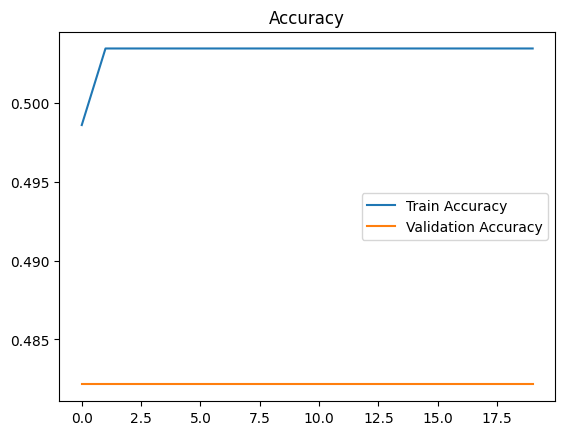

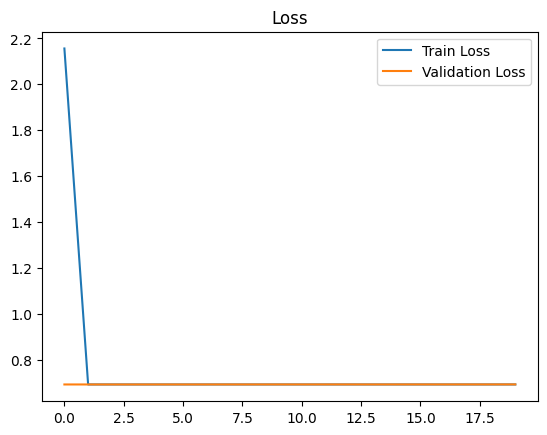

In [55]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy') # history.history['accuracy']: Contiene i valori di accuratezza calcolati dal modello su ogni epoca per il training set
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # history.history['val_accuracy']: valori calcolati sul validation set dopo ogni epoca, ci dice quanto bene il modello generalizza su dati non visti durante il training
plt.legend() # Stampa la leggenda in basso a dx
plt.title('Accuracy') # Da il titolo al grafico in alto
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss') # history.history['loss']: i valori della funzione di perdita calcolati dal modello sul training set durante ogni epoca
plt.plot(history.history['val_loss'], label='Validation Loss') # history.history['val_loss']: i valori calcolati sul validation set dopo ogni epoca, ci dice quanto bene il modello generalizza su dati non visti
plt.legend()
plt.title('Loss')
plt.show()


# 8. Identify FAKE videos

Per identificare i video di origine dei frame dichiarati FAKE in fase di testing, è stata tracciata l'associazione tra ciascun frame e il video da cui è stato estratto tramite un dizionario che memorizza l'origine dei frame, così da poter analizzare i risultati dei test.

In [56]:
# Test del modello
predictions = model.predict(X_test)  # Probabilità per ogni frame
predicted_labels = (predictions > 0.79).astype(int)  # Soglia: 0.79

# Trova i frame predetti come FAKE
fake_indices = np.where(predicted_labels == 1)[0]  # Indici dei frame FAKE

# Identifica i video di origine per i frame FAKE
fake_videos = [origins_test[i] for i in fake_indices]

print(f"Numero di frame FAKE identificati: {len(fake_indices)}")
print("Video di origine per i frame FAKE:")
for video in set(fake_videos):  # Usa set() per evitare duplicati
    print(video)


9/9 [==============================] - 19s 2s/step
Numero di frame FAKE identificati: 0
Video di origine per i frame FAKE:


# Consideration

1. Utilizzo dell'intero Dataset

Attualmente, il modello è stato addestrato utilizzando un dataset molto ristretto a causa di limitazioni computazionali. Aumentare il numero di dati di training è una delle strategie più efficaci per migliorare le prestazioni di un modello di deep learning. Più dati significano una maggiore varietà di situazioni e dettagli che il modello può imparare a riconoscere, riducendo il rischio di overfitting.

2. Modifica dell'Architettura del Modello

**Rilevamento dei Volti**

Attualmente, il modello utilizza Haar Cascades per il rilevamento dei volti, una tecnica rapida e relativamente semplice. Sebbene sia stata una scelta pratica per la compatibilità con CPU, ci sono alternative che potrebbero migliorare significativamente la precisione:

* Dlib (HOG + SVM): Rilevamento basato su Histogram of Oriented Gradients (HOG) e Support Vector Machine (SVM). Questo approccio, come Haar Cascades, funziona bene su CPU e offre una maggiore accuratezza nel rilevamento di volti.
* MTCNN: Un approccio avanzato basato su reti neurali convoluzionali, che rileva volti con maggiore precisione e supporta l'uso di GPU per accelerare il processo.
face_recognition: Una libreria basata su Dlib, che offre funzionalità di rilevamento dei volti ottimizzate e supporta l'elaborazione su GPU.

**Modello di Classificazione**

Per il task di classificazione, si potrebbe considerare di sostituire ResNet50 con architetture alternative che potrebbero offrire vantaggi specifici:

* VGG16: Una rete più semplice e interpretabile, utile per dataset di dimensioni limitate.
* Inception-v3: Un'architettura progettata per catturare caratteristiche multi-scala, che potrebbe migliorare la capacità del modello di rilevare dettagli complessi nei video manipolati.
* EfficientNet: Una rete moderna che bilancia potenza e risparmio computazionale, adatta per scenari con risorse limitate.

3. Applicare Tecniche di Fine-Tuning

Nell'esercizio corrente, tutti i pesi dei livelli convoluzionali del modello pre-addestrato sono stati congelati. Sebbene questo approccio sia utile per utilizzare il modello come estrattore di caratteristiche generali, sbloccare alcuni livelli per il fine-tuning può migliorare notevolmente l'adattamento del modello al problema specifico.

Il fine-tuning consiste nel:
* Sbloccare gli ultimi strati convoluzionali di ResNet50 (o del modello scelto).
* Consentire al modello di aggiornare i pesi durante l'addestramento sui nuovi dati.
* Utilizzare un learning rate ridotto per evitare di "dimenticare" ciò che il modello ha già appreso da ImageNet.



